In [6]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../../simulator/")
sys.path.append("../../fitting/")


from tissue import *
import tissplot as tplt
import matplotlib.path as mplPath
import analysis
import datasets as ds 
import tiss_optimize as topt
import sim_model

#Defining death profile
expdata = ds.load_object('../../experiment/ablation.pkl')


def death(t, tscale = 1, dshift = -1, tmin = -3, b1 = 3.2553e-2, b2 = 8.7969e-1, bx = 0.5240):
    t = t/tscale + dshift
    if type(t) == int or type(t) == float:
        t = np.array([t])
    y = np.zeros(len(np.array(t)))
    y[t >= 0] = np.exp(-bx*t[t >= 0])
    y[t  < 0] = np.exp(b1*(t[t < 0] - tmin))*(1 - np.exp(-b2*(t[t < 0] - tmin)))/np.exp(-tmin*b1)/(1 - np.exp(tmin*b2))
    y[t < tmin] = 0.0
    return y



In [ ]:

sp = 'binary'

s0 = topt.sim_anneal(sim_model.S_mech_switch, 
                     {'Ahigh': [1.5], 'tadiv': [10.0, 55.0],
                      'hilln': [0.625, 10.0], 'r': [0.25]}, 
                     params = {'rlambda': 1/21.2/tscale, 'switch_profile': sp,
                               'L': 15, 'tscale': tscale, 'deathscale': -1.4}, simtype = 'a',
                exp_file = 'ablation.pkl',  exp_prefix = 'exp', tshift = -5.0,
                   metrics = [{'cost': 'cost_prd', 'dist_metric': 'ksd', 
                               'dist': ['basalCS'], 'exclude_times': {'basalCS': [0,1,2]},
                               'quantity': ['density', 'divrate'], 'qmetric': 'pls'}],
                   move_seed = -1, use_linear = ['Ahigh', 'tadiv', 'r'],
                   move_sizes     = {'deathscale': 1.05, 'Ahigh': 0.05, 'tadiv': 5, 'r': 0.05, 'hilln': 2}, 
                   free_param_min = {'deathscale': -3.0,  'Ahigh': 1.0, 'tadiv': 4, 'r': 0.05, 'hilln': 0.1}, 
                   free_param_max = {'deathscale': -0.5,  'Ahigh': 2.2, 'tadiv': 150, 'r': 0.55, 'hilln': 10.0})



s0.load_existing(1500, 225, 'exp_S_mech_switch/')

sim_data = s0.get_best_fit('cost_prd_ksd_bas_av_pls_dens_dr', 1500, 225, savefolder = 'exp_S_mech_switch/', nseeds = 5,
                          norm_by_control = ['density', 'divrate'], save_results = False)
exp_data = s0.exp_data

plt.figure()
ds.plot_quantity('basalCS', sim_data, exp_data, sim_data.tscalevals[0],
                 ylabel = 'clone size', plot_seeded = False, prelabel = 'bas: ', bootSEs = True)
'''
ds.plot_quantity('av_tot_cs', sim_data, exp_data, sim_data.tscalevals[0],
                 ylabel = 'clone size', plot_seeded = False, prelabel = 'tot: ', color = 'r')
'''

plt.figure()
ds.plot_quantity('density', sim_data, exp_data, sim_data.tscalevals[0],
                 ylabel = 'Density', plot_seeded = False, prelabel = 'bas: ')

plt.figure()
ds.plot_quantity('divrate', sim_data, exp_data, sim_data.tscalevals[0],
                 ylabel = 'Division rate', plot_seeded = False, prelabel = 'bas: ')

In [3]:
#Plot a best fit


def death(t, tscale = 1, dshift = -1, tmin = -3, b1 = 3.2553e-2, b2 = 8.7969e-1, bx = 0.5240):
    t = t/tscale + dshift
    if type(t) == int or type(t) == float:
        t = np.array([t])
    y = np.zeros(len(np.array(t)))
    y[t >= 0] = np.exp(-bx*t[t >= 0])
    y[t  < 0] = np.exp(b1*(t[t < 0] - tmin))*(1 - np.exp(-b2*(t[t < 0] - tmin)))/np.exp(-tmin*b1)/(1 - np.exp(tmin*b2))
    y[t < tmin] = 0.0
    return y

i = -1
s0 = topt.sim_anneal(sim_model.S_mech_switch, 
                     {'deathscale': 0.0065, 'Ahigh': 1.0, 'tadiv': 70, 'r': 0.3}, 
                     params = {'tau': 1000.0, 'hilln': 2, 'switch_profile': 'relu',
                               'L': 15, 'tscale': 150}, simtype = 'a',
                exp_file = '../../experiment/ablation.pkl',  exp_prefix = 'exp', tshift = -5.0,
                   metrics = [{'cost': 'cost_prd', 'dist_metric': 'ksd', 
                               'dist': ['basalCS', 'supraCS'], 'exclude_times': {'basalCS': [0,1,2]},
                               'quantity': ['density', 'divrate'], 'qmetric': 'pls'}],
                   move_seed = i, use_linear = ['Ahigh', 'tadiv', 'r'],
                   move_sizes     = {'deathscale': 1.05, 'Ahigh': 0.05, 'tadiv': 5, 'r': 0.05}, 
                   free_param_min = {'deathscale': -3.0,  'Ahigh': 1.0, 'tadiv': 5, 'r': 0.05}, 
                   free_param_max = {'deathscale': -0.5,  'Ahigh': 2.2, 'tadiv': 150, 'r': 0.55},
                   toCalculate = ['pers', 'supraCS', 'totalCS'])


s0.runSA(ncells = 225, tsteps = 5000, seeds = np.arange(10), savefolder = 'exp_S_relu/',
           tscalevals = [150], shedvals = -np.arange(0.1, 0.1, 5.0),
           use_saved_metrics = False, ncores = 1, save_every = 5, mergefirst = False, 
           SAsteps = 0, T0 = 0.1, start_idx = 0,
           sim_args = {'p0': 3.5}, norm_by_control = ['density', 'divrate'], 
           init_params = {'relaxsteps': 1500, 'homeosteps': 2000, 'ctrsteps': 2000, 
                          'kill_fn': death, 'kill_params': {'dshift': -6}})

Starting at: Thu Jun 27 10:10:03 2024
Optimising parameters, init params: {'Ahigh': np.float64(1.0), 'L': np.int64(15), 'deathscale': np.float64(0.0065), 'hilln': np.int64(2), 'r': np.float64(0.3), 'switch_profile': 'relu', 'tadiv': np.float64(70.0), 'tau': np.float64(1000.0), 'tscale': np.int64(150)} seed: -1
Min params: {'deathscale': -3.0, 'Ahigh': 1.0, 'tadiv': 5, 'r': 0.05}
Max params: {'deathscale': -0.5, 'Ahigh': 2.2, 'tadiv': 150, 'r': 0.55}
Move sizes: {'deathscale': 1.05, 'Ahigh': 0.05, 'tadiv': 5, 'r': 0.05}
Running for: {'Ahigh': np.float64(1.0), 'L': np.int64(15), 'deathscale': np.float64(0.0065), 'hilln': np.int64(2), 'r': np.float64(0.3), 'switch_profile': 'relu', 'tadiv': np.float64(70.0), 'tau': np.float64(1000.0), 'tscale': np.int64(150)}
File already exists: arun_S_mech_switch_t_5000_n_225_Ahigh_1.0_L_15_deathscale_0.0065_hilln_2_r_0.3_switch_profile_relu_tadiv_70.0_tau_1000.0_tscale_150_seed_0.pkl
File already exists: arun_S_mech_switch_t_5000_n_225_Ahigh_1.0_L_15_d

Best fit: index                                                               0
deathscale                                                     0.0065
Ahigh                                                             1.0
tadiv                                                            70.0
r                                                                 0.3
tau                                                            1000.0
hilln                                                               2
switch_profile                                                   relu
L                                                                  15
tscale                                                          150.0
maxseed                                                             9
cost_prd_ksd_bas_sup_av_pls_dens_dr_excld_0_1_2              5.272371
cost_prd_ksd_bas_sup_av_pls_dens_dr_excld_0_1_2:shed              0.0
cost_prd_ksd_bas_sup_av_pls_dens_dr_excld_0_1_2:tscale          150.0
cost_prd_k

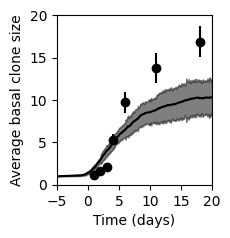

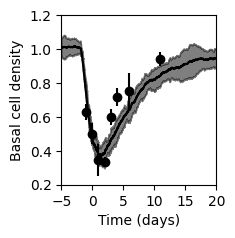

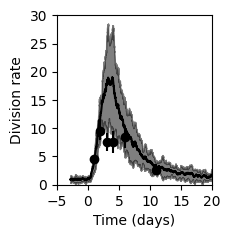

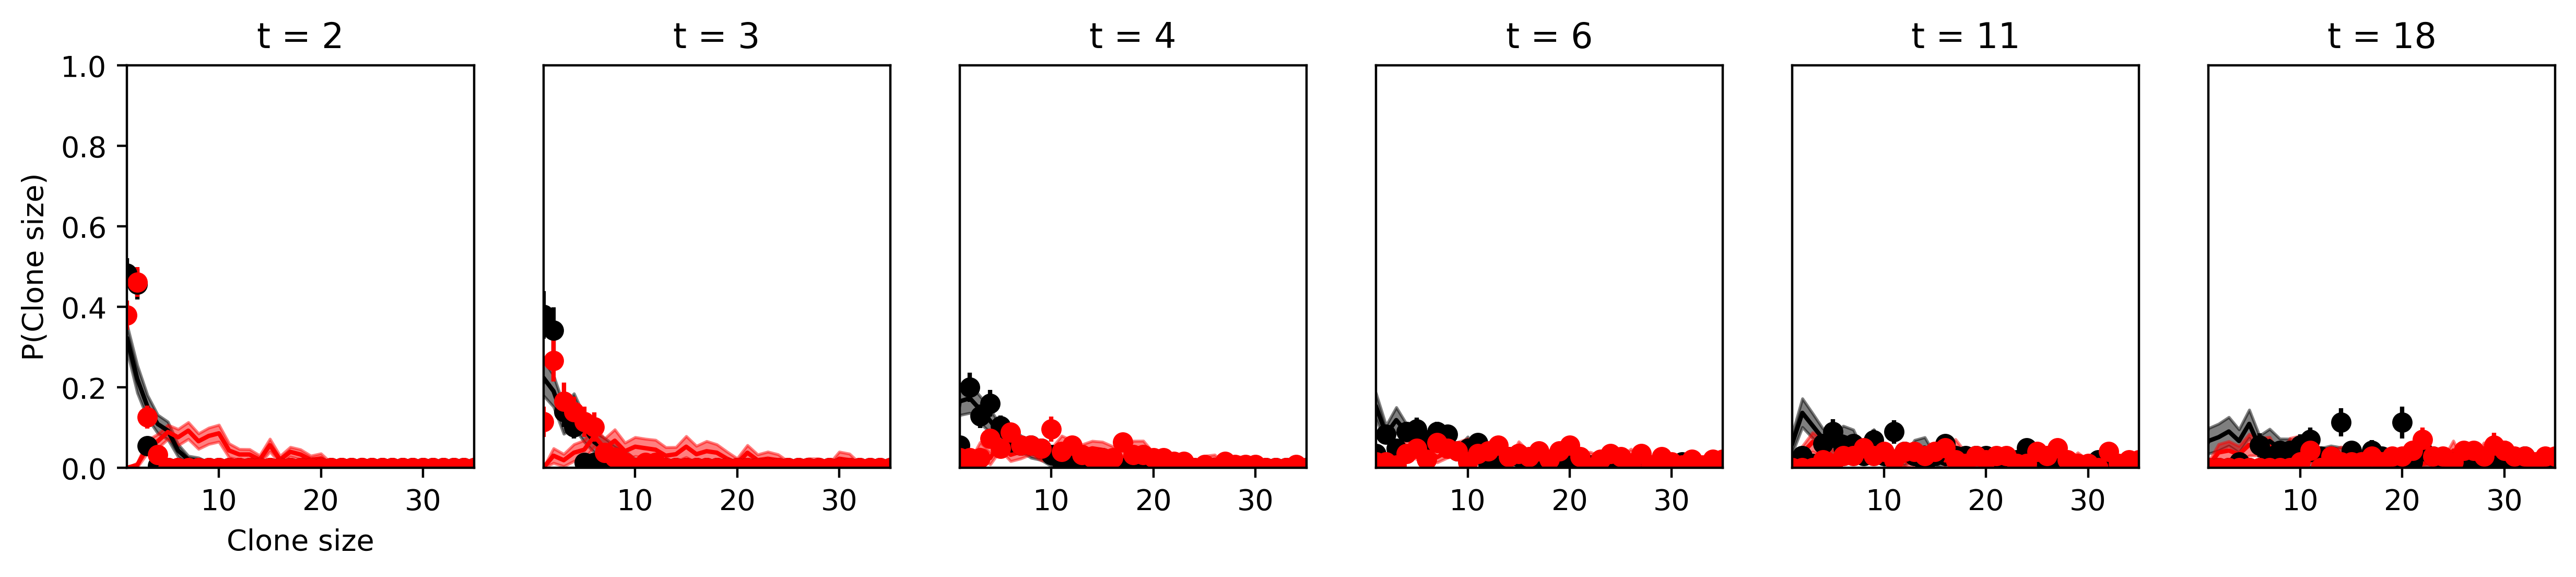

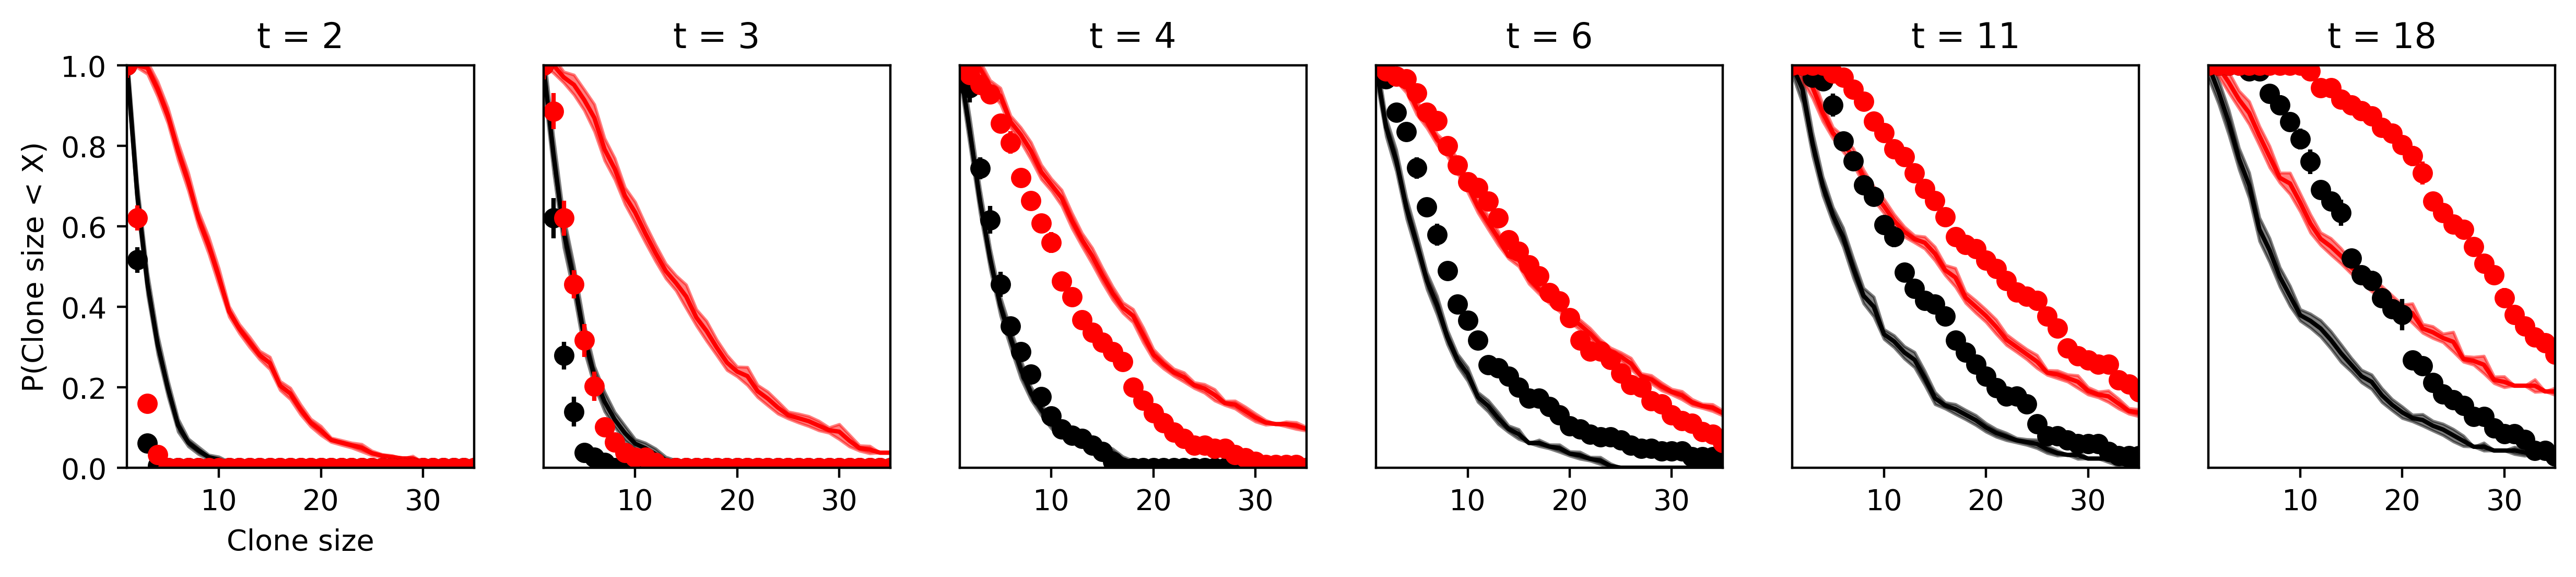

In [4]:
import datasets as ds

deathprofile = np.ones(5000)*(1000*0.25)**(-1)
deathprofile[ds.exp2simTimes(6,  150.0, 5):] = (1000*0.3)**(-1)
deathprofile[ds.exp2simTimes(11, 150.0, 5):] = (1000*0.5)**(-1)
s0.tscalevals = [150]

sim_data = s0.get_best_fit('cost_prd_ksd_bas_sup_av_pls_dens_dr_excld_0_1_2', 5000, 225, 
                           savefolder = 'exp_S_relu/', nseeds = 10, save_results = True,
                           norm_by_control = ['density', 'divrate'], shed_profile = deathprofile)


exp_data = s0.exp_data

ds.save_object({'sim_data': sim_data, 'exp_data': exp_data}, 'best_exp_fits.pkl')


plt.figure(figsize=(2.0,2.2))
plt.margins(x=0) 
plt.margins(y=0) 
ds.plot_quantity('basalCS', sim_data, exp_data, sim_data.tscalevals[0],
                 ylabel = 'Average basal clone size', plot_seeded = False, prelabel = 'bas: ', bootSEs = True, errmult = 1.96)
plt.gca().get_legend().remove()
plt.xlim([-5,20])
plt.ylim([0, 20])
plt.yticks(np.arange(0,21,5))
plt.xticks(np.arange(-5,21,5))
plt.savefig('SFig3S_mean_clone_size.pdf', dpi = 400, bbox_inches='tight')

plt.figure(figsize=(2.0,2.2))
plt.margins(x=0) 
plt.margins(y=0) 
ds.plot_quantity('density', sim_data, exp_data, sim_data.tscalevals[0],
                 ylabel = 'Basal cell density', plot_seeded = False, prelabel = 'bas: ', errmult = 1.96)
plt.gca().get_legend().remove()
plt.xticks(np.arange(-5,21,5))
plt.xlim([-5,20])
plt.ylim([0.2,1.2])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0,1.2])
plt.savefig('SFig3S_density.pdf', dpi = 400, bbox_inches='tight')

plt.figure(figsize=(2.0,2.2))
plt.margins(x=0) 
plt.margins(y=0) 
ds.plot_quantity('divrate', sim_data, exp_data, sim_data.tscalevals[0],
                 ylabel = 'Division rate', plot_seeded = False, prelabel = 'bas: ', errmult = 1.96, sim_shift = 2.0,
                 sim_slice = [25, -25])
plt.gca().get_legend().remove()
plt.xticks(np.arange(-5,21,5))
plt.xlim([-5,20])
plt.ylim([0,30])
plt.yticks(np.arange(0,31,5))
plt.savefig('SFig3J_divrate.pdf', dpi = 400, bbox_inches='tight')



axs = ds.plot_dist('basalCS', sim_data, exp_data, subtimes= np.arange(1,7), maxbin = 35, cdf = False, xlabel= 'Clone size', prelabel= 'bas: ', bootSEs = True, overhang_in_last=False)
axs = ds.plot_dist('totalCS', sim_data, exp_data, subtimes= np.arange(1,7), maxbin = 35, cdf = False, xlabel= 'Clone size', prelabel= 'tot: ', color = 'r', subplot_axs=axs, bootSEs = True, overhang_in_last=False)

axs = ds.plot_dist('basalCS', sim_data, exp_data, subtimes= np.arange(1,7), maxbin = 35, cdf = True, xlabel= 'Clone size', prelabel= 'bas: ', bootSEs = True, overhang_in_last=False)
axs = ds.plot_dist('totalCS', sim_data, exp_data, subtimes= np.arange(1,7), maxbin = 35, cdf = True, xlabel= 'Clone size', prelabel= 'tot: ', color = 'r', subplot_axs=axs, bootSEs = True, overhang_in_last=False)
